# 1. Install Dependencies and Setup

In [1]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
asgiref                       3.6.0
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrdict                      2.0.1
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
bea

In [3]:
import tensorflow as tf
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2023-02-16 17:52:00.184010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-16 17:52:00.192776: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-16 17:52:00.192832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (revivephoenix-007): /proc/driver/nvidia/version does not exist


In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'Dataset' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('Dataset')

Found 483 files belonging to 2 classes.


2023-02-16 17:53:11.220859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

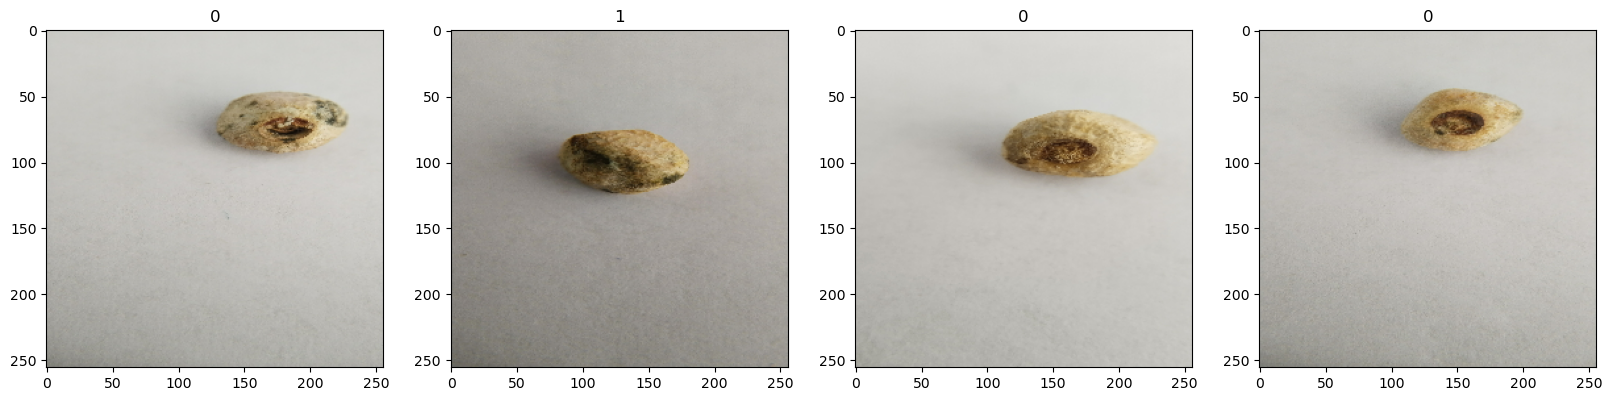

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
data.as_numpy_iterator().next()

(array([[[[0.76887256, 0.7767157 , 0.7612745 ],
          [0.7704657 , 0.77230394, 0.75894606],
          [0.76589406, 0.7698156 , 0.7491594 ],
          ...,
          [0.8068082 , 0.80705327, 0.78928363],
          [0.8047507 , 0.81021845, 0.7906106 ],
          [0.80423754, 0.80856216, 0.79816175]],
 
         [[0.761579  , 0.76550055, 0.74230814],
          [0.7655819 , 0.76166034, 0.74597406],
          [0.771313  , 0.76739144, 0.7477836 ],
          ...,
          [0.8104368 , 0.8065152 , 0.79082894],
          [0.8055147 , 0.80943626, 0.78590685],
          [0.8060518 , 0.80997336, 0.7903655 ]],
 
         [[0.7691856 , 0.76526403, 0.7470043 ],
          [0.77254903, 0.76862746, 0.7490196 ],
          [0.77408665, 0.7701651 , 0.75055724],
          ...,
          [0.80919117, 0.8052696 , 0.7895833 ],
          [0.80919117, 0.8052696 , 0.78566176],
          [0.80795896, 0.8118805 , 0.7922727 ]],
 
         ...,
 
         [[0.5011853 , 0.50510687, 0.48292547],
          [0.49960

# 5. Split Data

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train_size

11

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [21]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
11/11 [==============================] - 14s 827ms/step - loss: 1.1366 - accuracy: 0.4148 - val_loss: 0.6872 - val_accuracy: 0.6771
Epoch 2/20
11/11 [==============================] - 13s 950ms/step - loss: 0.6409 - accuracy: 0.6676 - val_loss: 0.6009 - val_accuracy: 0.6875
Epoch 3/20
11/11 [==============================] - 13s 921ms/step - loss: 0.6260 - accuracy: 0.6534 - val_loss: 0.6108 - val_accuracy: 0.6458
Epoch 4/20
11/11 [==============================] - 12s 882ms/step - loss: 0.6125 - accuracy: 0.6591 - val_loss: 0.5859 - val_accuracy: 0.6771
Epoch 5/20
11/11 [==============================] - 12s 888ms/step - loss: 0.5936 - accuracy: 0.7131 - val_loss: 0.5368 - val_accuracy: 0.6979
Epoch 6/20
11/11 [==============================] - 12s 888ms/step - loss: 0.4828 - accuracy: 0.7756 - val_loss: 0.3387 - val_accuracy: 0.8333
Epoch 7/20
11/11 [==============================] - 13s 943ms/step - loss: 0.5628 - accuracy: 0.7244 - val_loss: 0.5722 - val_accuracy: 0.7917

# 8. Plot Performance

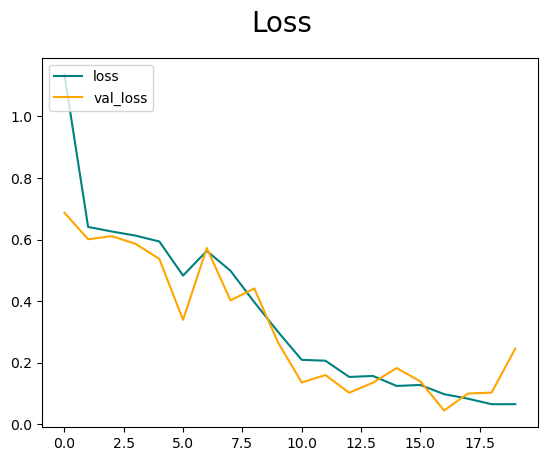

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

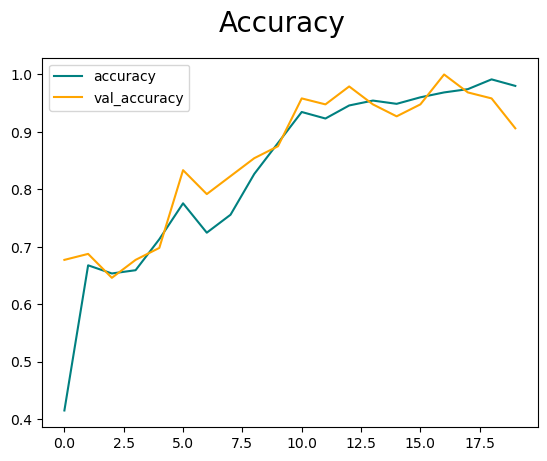

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 234ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [36]:
import cv2

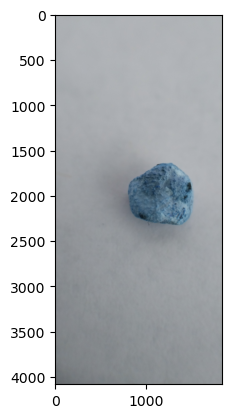

In [43]:
img = cv2.imread('I_b.jpg')
plt.imshow(img)
plt.show()

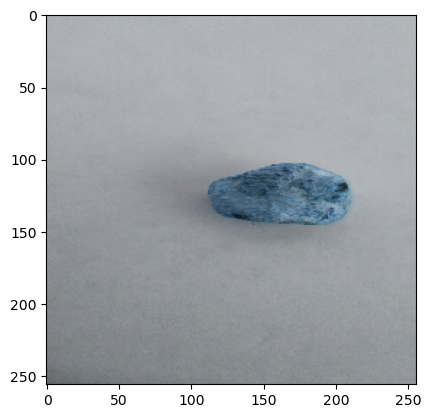

In [44]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [45]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 20ms/step


In [46]:
yhat

array([[0.9877839]], dtype=float32)

In [47]:
if yhat > 0.5: 
    print(f'Predicted class is Bad not germinated seed')
else:
    print(f'Predicted class is Good/Germinated Seed with Embryo and Endosperms')

Predicted class is Bad not germinated seed


# 11. Save the Model

In [48]:
from tensorflow.keras.models import load_model

In [49]:
model.save(os.path.join('models','imageclassifier.h5'))

In [50]:
new_model = load_model('imageclassifier.h5')

OSError: No file or directory found at imageclassifier.h5

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))